In [2]:
from astropy.io.fits import getdata
import glob
from matplotlib import pyplot as plt
import os
from astropy.table import Table
import corner
import pandas as pd
from astropy import units as u
from scipy import optimize

import numpy as np

calsrc_gain_shift = {}
calsrc_gain_shift['A'] ={
                'det0':0.9933,
                'det1':0.9919,
                'det2':0.9993,
                'det3':0.9973
                }
calsrc_gain_shift['B'] = {
                'det0':0.9955,
                'det1':0.9929,
                'det2':0.9928,
                'det3':0.9960
                }
import matplotlib

font = {'size'   : 16}
matplotlib.rc('font', **font)


In [3]:
def piecewise_linear(t, en0, change1, shift1, change2, shift2):

    dt1 = change1    
    dt2 = np.max(t) - change2
   
    f1 = lambda t: en0 * ( 1 - (1.0 - shift1) * t / dt1)
    f2 = lambda t: en0 * shift1
    f3 = lambda t: (en0 * shift1) * (1.0 - (1.0 - shift2) * (t - change2) / dt2)

    fx = np.select( [t < change1, (t>=change1) & (t<change2), t>=change2], [f1(t), f2(t), f3(t)])

    return fx
    



In [4]:
def load_chain(chain_file, test_entry='LineE__1'):
    chain = Table.read(chain_file)
    df = chain.to_pandas()

    for entry in df:
        if test_entry != entry:
            continue


        q = corner.quantile(df[entry], [0.16, 0.5, 0.84])
        cent = q[1]
        err = 0.5* ((q[1] - q[0]) + (q[2] - q[1]))
    return cent, err




In [9]:
def loop_epochs(det='0', mod = 'A', fit_change1=False, fit_change2 = False, free_drift=False, fit_line=False,showFit=True):
    
    gain_met = 159663600. # from CALDB file
    launch_met=77241600. # 2012-06-13T00:00:00

    gain_date = ((gain_met - launch_met)*u.s).to(u.yr).value
    epochs_per_yr = 2.

    change1 = gain_date*epochs_per_yr
    change2 = 8.0

    
    
    chain_files = sorted(glob.glob('epoch*det{}*FPM{}*chain.fits'.format(det, mod)))
    epochs = []
    line_cent = []
    line_err = []
    # Get 105.3 keV fits
    for file in chain_files:
        epoch_str = (file.split('_'))[0]
        epoch = float((epoch_str[5:]))

        epochs.append(epoch)
        cent, err = load_chain(file)
        line_cent.append(float(cent))
        line_err.append(float(err))

        
    epochs = np.array(epochs)
    td = np.linspace(0, np.max(epochs), 40)
    
    gain_drift = calsrc_gain_shift[mod][f'det{det}']
    
#     if mod == 'A':
#         gain_drift = fpma_gain_shift['det{}'.format(det)]
#     else:
#         gain_drift = fpmb_gain_shift['det{}'.format(det)]

        
    p0 = [105.3, change1, gain_drift, 8.0, 0.997]
    
    if fit_line is True:
        line_tol = 1.
    else:
        line_tol = 1e-3
    
    if free_drift:
        drift_tol = 1e-2
    else:
        drift_tol = 1e-5
    
    if fit_change1:
        change1_tol = 2.
    else:
        change1_tol = 1e-4
    
    if fit_change2:
        change2_tol = 8. - change1 
    else:
        change2_tol = 1e-4
 
    
    bounds = ([105.3-line_tol, change1-change1_tol, gain_drift-drift_tol, change2 - change2_tol, 0.9 ],
              [105.3+line_tol, change1+change1_tol, gain_drift + drift_tol, change2 + change2_tol, 1.1])
        
    
    
    # Do piecewise linear fit
    p , pcov = optimize.curve_fit(piecewise_linear, epochs, line_cent, sigma=line_err, p0 = p0,
                              bounds = bounds)

    
    
    #     # Load 144 keV line:
    

    line_cent144 = []
    line_err144 = []
    for file in chain_files:
        cent, err = load_chain(file, test_entry='LineE__4')
        line_cent144.append(float(cent))
        line_err144.append(float(err))



    p144_0 = np.copy(p)
    p144_0[0] = 144.5
    drift_tol = 1e-4
    line_tol = 0.5
    bounds = ([144.5-0.5, p[1]-1e-5, p[2]-1e-4, p[3]-1e-4, p[4]-1e-4 ],
              [144.5+0.5, p[1], p[2], p[3], p[4]])
    p144 , e = optimize.curve_fit(piecewise_linear, epochs, line_cent144, sigma=line_err144, p0 = p144_0,
                              bounds = bounds)

 

    if showFit:
        print('First guess: ', p0)
        print('Fit: ', p)
        perr = np.sqrt(np.diag(pcov))
        print('Errors: ', perr)

        print('Fit to 144.5 keV line')
        print(p144)
        est_lines = piecewise_linear(epochs, *p)
        est_lines144 = piecewise_linear(epochs, *p144)

        fig = plt.figure(figsize=[12, 8])

        epochs *= 0.5
        
        plt.errorbar(epochs, line_cent, line_err, fmt='.')

        plt.plot(epochs, est_lines, '.', markersize=12)
        plt.xlabel('Years since launch')
        plt.ylabel('Apparent 105.3 keV line energy')

        plt.axvline(p[1]*0.5, c='red', linestyle='dashed')
        plt.axvline(p[3]*0.5, c='red', linestyle='dashed')


        plt.show()

        fig = plt.figure(figsize=[12, 8])


        plt.errorbar(epochs, line_cent / est_lines, line_err / est_lines, fmt = '.')
        plt.xlabel('Years since launch')
        plt.ylabel('Residual Gain Differences')

        plt.show()

        fig = plt.figure(figsize=[12, 8])


        plt.errorbar(epochs, line_cent144, line_err144, fmt='.')

        plt.ylabel('Apparent 144 keV line energy')
        plt.xlabel('Years since launch')


        plt.plot(epochs, est_lines144, '.', markersize=12)
        
        plt.show()
        fig = plt.figure(figsize=[12, 8])


        plt.errorbar(epochs, line_cent144 / est_lines144, line_err144 / est_lines144, fmt = '.')
        plt.ylabel('Residual gain differences @144 keV')
        plt.xlabel('Years since launch')
 
        plt.show()
    return p


In [69]:
from importlib import reload
from nustar_gen import info
reload(info)
from astropy.time import Time
import astropy.units as u
ns = info.NuSTAR()

In [78]:
for mod in ['A', 'B']:
    best_fits = f'gain_fit_{mod}.txt'
    f = open(best_fits, 'w')
    for det in range(4):
        base_drift = calsrc_gain_shift[mod][f'det{det}']
        if mod is 'A' and det == 3:
            fit_pars = loop_epochs(mod=mod,det = f'{det}', fit_line=True, showFit=False, fit_change2=True)
        else:            
            fit_pars = loop_epochs(mod=mod,det = f'{det}', fit_line=True, showFit=False)

            
        epoch_change = (ns.launch + 0.5*fit_pars[3] * u.yr)
        epoch_change_met = ns.time_to_met(epoch_change)
        last_epoch = (ns.launch + (0.5*14 * u.yr).to(u.day))
        last_epoch_met = ns.time_to_met(last_epoch)

        print(mod, det)
        print(epoch_change, epoch_change_met)
        print(last_epoch, last_epoch_met)

        f.write(f'{det} {epoch_change_met} {fit_pars[2]/base_drift}\n')
        f.write(f'{det} {last_epoch_met} {fit_pars[4]}\n')

    f.close()

A 0
2016-06-13T00:26:15.880 203473577.87999997
2019-06-13T17:59:57.000 298144800.0
A 1
2016-06-12T23:59:58.755 203472000.75453082
2019-06-13T17:59:57.000 298144800.0
A 2
2016-06-12T23:33:40.120 203470422.12000003
2019-06-13T17:59:57.000 298144800.0
A 3
2015-01-22T22:59:59.010 159663600.01039648
2019-06-13T17:59:57.000 298144800.0
B 0
2016-06-12T23:33:40.120 203470422.12000003
2019-06-13T17:59:57.000 298144800.0
B 1
2016-06-12T23:33:40.120 203470422.12000003
2019-06-13T17:59:57.000 298144800.0
B 2
2016-06-12T23:33:40.120 203470422.12000003
2019-06-13T17:59:57.000 298144800.0
B 3
2016-06-12T23:33:40.120 203470422.12000003
2019-06-13T17:59:57.000 298144800.0


First guess:  [105.3, 5.223591147615788, 0.9933, 8.0, 0.997]
Fit:  [105.42916112   5.22369115   0.99331      8.0001       0.99529891]
Errors:  [4.55618476e-02 5.46834403e-01 5.62074934e-04 8.65448688e-01
 5.56122840e-04]
Fit to 144.5 keV line
[144.59608711   5.22368115   0.99331      8.           0.99529891]


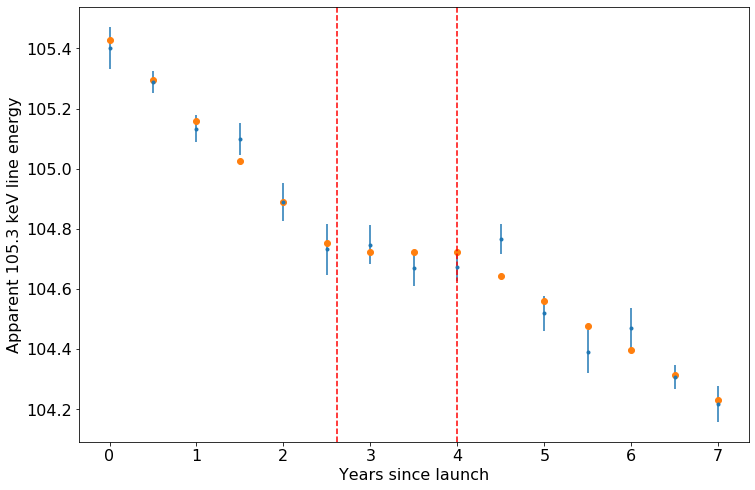

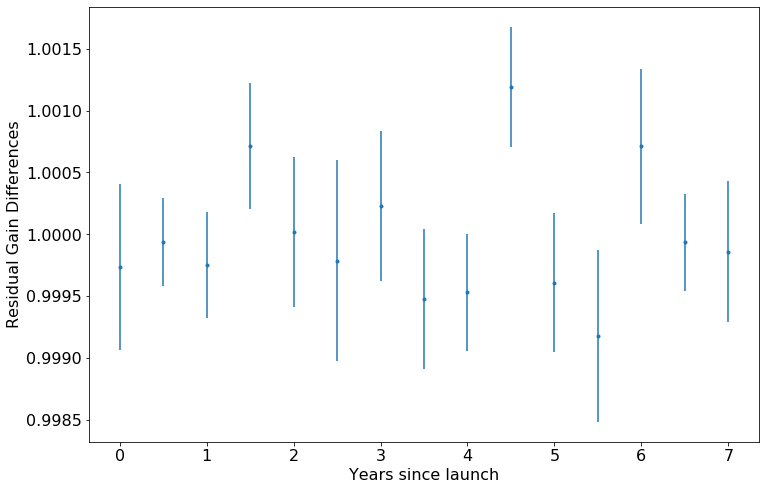

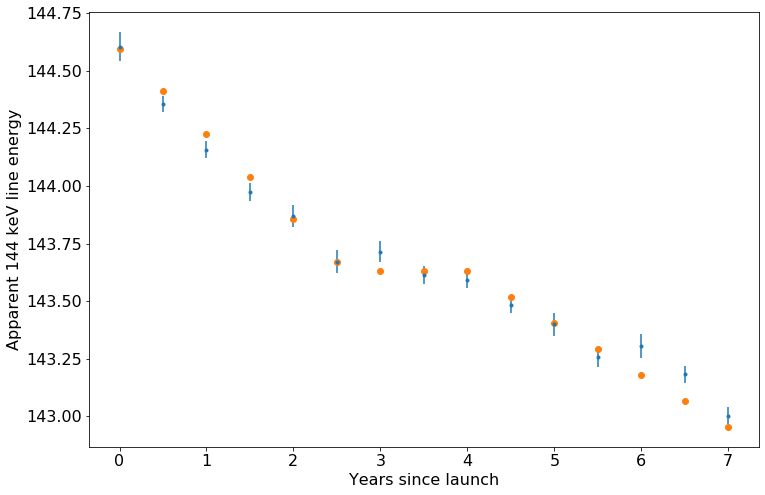

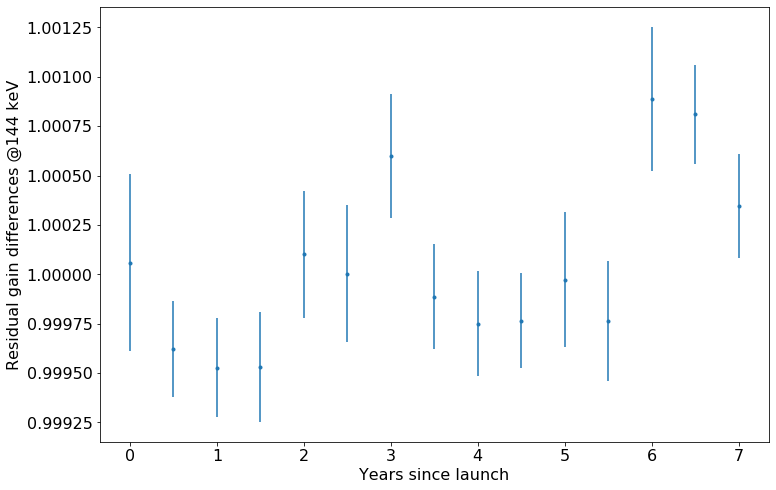

In [10]:
fit_pars = loop_epochs(mod='A',det = '0',  fit_line=True, showFit=True)

In [61]:
print(fit_pars)
print((1.0 - fit_pars[2])/fit_pars[1])
print((1.0 - fit_pars[4])/(14.-fit_pars[3]))

[105.60042035   5.22349115   0.9972       5.22359115   0.99272855]
0.0005360399627130499
0.0008285223095589478
